In [1]:
#Load libraries 
import sspa
import networkx as nx
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

### Check sample overlap between datasets

In [ ]:
df = pd.read_csv('Data/Su_COVID_metabolomics_processed_ChEBI.csv', index_col=0)
df2 = pd.read_csv('Data/Su_COVID_proteomics_processed.csv', index_col=0)

In [ ]:
df.index= df.index.str.rstrip('-BL')  #remove 'BL' label from the cases (so I can match to proteomic data)

In [ ]:
def sample_overlap(status):
    list1 = list(df[df['WHO_status']== status].index)
    list2 = list(df2[df2['WHO_status']== status].index)
    #print(list1)
    #print(list2)
    intersection = list(set(list1).intersection(list(set(list2))))  #set removes duplicates
    print(status, "      Common samples:",len(intersection),"         Metabolomic samples:",len(list1),"       Proteomic samples:",len(list2))
    #print(set(list1) - set(list2),set(list2) - set(list1))   #Different samples between the two

sample_overlap('0')
sample_overlap('1-2')
sample_overlap('3-4')
sample_overlap('5-7')

#print(df['WHO_status'].value_counts()) 

In [ ]:
df = pd.read_csv('Data/Su_COVID_metabolomics_processed_ChEBI.csv', index_col=0)
df2 = pd.read_csv('Data/Su_COVID_proteomics_processed.csv', index_col=0)

df.index= df.index.str.rstrip('-BL')  #remove 'BL' label from the cases (so I can match to proteomic data)

list1 = list(df.index)
list2 = list(df2.index)
#print(list1)
#print(list2)
intersection = list(set(list1).intersection(list(set(list2))))  #set removes duplicates

print(len(intersection))

### Obtaining pathway names for the graph

In [2]:
#Load dataset
metabolomic = nx.read_gml("Cytoscape/metabolomic_prefiltered.gml")
proteomic = nx.read_gml("Cytoscape/proteomic_prefiltered.gml")


In [2]:
#Load dataset
#This is when the pathway scores are calculated subset to the 128 SAMPLES common to both datasets
#metabolomic = nx.read_gml("Cytoscape/metabolomic_prefiltered_commonsamples.gml")
#proteomic = nx.read_gml("Cytoscape/proteomic_prefiltered_commonsamples.gml")

#metabolomic = nx.read_gml("Cytoscape/metabolomic_prefiltered_mildcases.gml")
#proteomic = nx.read_gml("Cytoscape/proteomic_prefiltered_mildcases.gml")

metabolomic = nx.read_gml("Cytoscape/metabolomic_prefiltered_severecases.gml")
proteomic = nx.read_gml("Cytoscape/proteomic_prefiltered_severecases.gml")

In [3]:
print(proteomic.number_of_nodes())
print(proteomic.number_of_edges())

print(metabolomic.number_of_nodes())
print(metabolomic.number_of_edges())

#Pathways in common
common_nodes = list(set(proteomic.nodes).intersection(list(set(metabolomic.nodes))))
len(common_nodes)

578
166753
144
10296


47

In [4]:
#Filter out pathways that are not present in both omic sets

proteomic_copy =  proteomic.copy()
for n in list(proteomic.nodes()):
    if n not in common_nodes:
        proteomic_copy.remove_node(n)

metabolomic_copy =  metabolomic.copy()
for n in list(metabolomic.nodes()):
    if n not in common_nodes:
        metabolomic_copy.remove_node(n)



### Plot the parameter values for both omics datasets 

In [ ]:
def find_val(list1,list2,value):
    for node1, node2, data in proteomic_copy.edges(data=True):
        list1.append(data[value])
    for node1, node2, data in metabolomic_copy.edges(data=True):
        list2.append(data[value])


In [ ]:
proteomic_pval = []
metabolomic_pval = []

find_val(proteomic_pval,metabolomic_pval,'Spearman_pval')

#It's not possible to take the log10 of zero, we ignore the divide by zero warning
#Transform the p-values on a -log10 scale
#Any infinite values after the log-transform were originally zeroes

np.seterr(divide = 'ignore')    

log_proteomic_pval = -np.log10(proteomic_pval)
log_metabolomic_pval = -np.log10(metabolomic_pval)

np.seterr(divide = 'warn') 
    

In [ ]:
print(np.median(proteomic_pval))
print(np.median(metabolomic_pval))

print(np.mean(proteomic_pval))
print(np.mean(metabolomic_pval))

print(sum(i == 1  for i in metabolomic_pval))

In [ ]:
sns.scatterplot(x=log_proteomic_pval, y=log_metabolomic_pval,s=8)       #color='#FFD580',s=10
                
plt.title('Comparison of Spearman correlation p-values',fontsize=16)
plt.xlabel("Proteomic Spearman p-values (-log10)",fontsize=13, labelpad=5)
plt.ylabel("Metabolomic Spearman p-values (-log10)",fontsize=13, labelpad=10) 

#Changing the axis limits to focus on the significant area only
#plt.xlim(-np.log10(0.005),)   #-log_10(0.005) = 2.301...
#plt.ylim(-np.log10(0.005),)

#plt.savefig('Figures/omics_Spearman_pval.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
proteomic_corr = []
metabolomic_corr = []
find_val(proteomic_corr,metabolomic_corr,'Squared_corr')


sns.scatterplot(x=proteomic_corr, y=metabolomic_corr,s=8)       #color='#FFD580',s=10
                
plt.title('Comparison of squared Spearman correlation coefficients',fontsize=16)
plt.xlabel("Proteomic Spearman correlation",fontsize=13, labelpad=5)
plt.ylabel("Metabolomic Spearman correlation",fontsize=13, labelpad=10) 

#plt.savefig('Figures/omics_spearman_corr.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
print(np.median(proteomic_corr))
print(np.median(metabolomic_corr))

print(np.mean(proteomic_corr))
print(np.mean(metabolomic_corr))

In [ ]:
proteomic_oc = []
metabolomic_oc = []

find_val(proteomic_oc,metabolomic_oc,'Overlap_coef')

sns.scatterplot(x=proteomic_oc, y=metabolomic_oc,s=8)       #color='#FFD580',s=10
                
plt.title('Comparison of overlap coefficients',fontsize=16)
plt.xlabel("Proteomic overlap coefficient",fontsize=13, labelpad=5)
plt.ylabel("Metabolomic overlap coefficient",fontsize=13, labelpad=10) 

#plt.savefig('Figures/omics_overlap_coef.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

Since there are fewer points observed than expected, it is possible that many of the points are overlapping.
Therefore we should plot a regression line to check if there is a trend, and also to reduce the point transparency.

In [ ]:
#Obtain regression values
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

plot = sns.regplot(x=proteomic_oc, y=metabolomic_oc,scatter_kws={'s':5,'alpha':0.3},line_kws={'linewidth':2})  #,color='red,x_jitter=0.005,y_jitter=0.005
plt.title('Comparison of overlap coefficients',fontsize=16)
plt.xlabel("Proteomic overlap coefficient",fontsize=13, labelpad=5)
plt.ylabel("Metabolomic overlap coefficient",fontsize=13, labelpad=10) 

res = scipy.stats.linregress(x=proteomic_oc, y=metabolomic_oc)
print(f"R-squared: {res.rvalue**2:.6f}")
plt.rcParams['font.size'] = 14  #change font size of the r-squared label
plt.text(0.5, 0.25, f"R-squared: {res.rvalue**2:.6f}")

#plt.savefig('Figures/omics_overlap_coef.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


In [ ]:
print(np.median(proteomic_oc))
print(np.median(metabolomic_oc))

print(np.mean(proteomic_oc))
print(np.mean(metabolomic_oc))

print(sum(i == 0  for i in metabolomic_oc))
print(sum(i == 0  for i in proteomic_oc))

### Method 1 - Combine both pre-filtered networks together and combine the p-values

The networks were constructed in NetworkX but the edges have not been filtered out

In [5]:
#https://networkx.org/documentation/stable/reference/algorithms/operators.html
# compose = "Compose graph G with H by combining nodes and edges into a single graph."

#If networks have the same edge, keep the attributes of the last network
#I.e. Right now the edges have the metabolite edge attributes
G = nx.compose(proteomic_copy,metabolomic_copy)

#len(proteomic_copy.edges & metabolomic_copy.edges)
#nx.draw(G, with_labels = True)

print(G.edges['R-HSA-112315', 'R-HSA-1483257'])

{'Squared_corr': 0.10747970859180164, 'Spearman_pval': 1.0, 'Overlap_coef': 0.2}


Combining the p-values

In [6]:
#Using Fisher's method to combine the p-values: Example code
p_values_list= [5.202380530055585e-20, 7.5913348658720385e-25]
print(scipy.stats.combine_pvalues(p_values_list, method='fisher'))  #output gives two numbers; first is the test statistic, second is the p-value (what we want)

#Using harmonic mean p-value method to combine the p-values: Example code
scipy.stats.hmean(p_values_list)


SignificanceResult(statistic=199.8804108441174, pvalue=3.986432815011612e-42)


1.5182448188841517e-24

In [7]:
edge_dict = {e: ([   proteomic_copy.edges[e]['Spearman_pval']  ,  metabolomic_copy.edges[e]['Spearman_pval']  ]) for e in proteomic_copy.edges & metabolomic_copy.edges}
print(edge_dict)

combined_pvals_fisher = []
combined_pvals_hmean = []

for k,v in edge_dict.items():

    #Fisher's method
    test_stat,pval = scipy.stats.combine_pvalues(v, method='fisher',weights=None)
    combined_pvals_fisher.append(pval)

    #Harmonic mean p-value
    combined_pvals_hmean.append(scipy.stats.hmean(v))

    

print(combined_pvals_fisher)
print(combined_pvals_hmean)

print(sum(i < 0.005 for i in combined_pvals_fisher))
print(sum(i < 0.005  for i in combined_pvals_hmean))

{('R-HSA-381340', 'R-HSA-428157'): [1.0, 1.0], ('R-HSA-2980736', 'R-HSA-8978868'): [1.0, 6.248427004303288e-15], ('R-HSA-1483257', 'R-HSA-15869'): [1.0, 1.0], ('R-HSA-156580', 'R-HSA-416476'): [1.052269596433604e-15, 1.0], ('R-HSA-112315', 'R-HSA-1428517'): [9.009060545876318e-17, 1.0], ('R-HSA-112315', 'R-HSA-8956319'): [1.0, 1.0], ('R-HSA-1592230', 'R-HSA-196849'): [1.0, 1.0], ('R-HSA-1483257', 'R-HSA-196071'): [1.0, 1.0], ('R-HSA-418555', 'R-HSA-500792'): [1.0, 1.0], ('R-HSA-196854', 'R-HSA-71406'): [4.28262333988056e-07, 1.0], ('R-HSA-2142753', 'R-HSA-597592'): [0.0010204570211029638, 1.0], ('R-HSA-196849', 'R-HSA-70326'): [1.0, 1.0], ('R-HSA-5663205', 'R-HSA-9711123'): [4.520095285430406e-23, 1.0], ('R-HSA-388396', 'R-HSA-8978868'): [4.780975665037253e-10, 2.9930468750689806e-09], ('R-HSA-71291', 'R-HSA-9707616'): [0.01890188355187881, 1.0], ('R-HSA-372790', 'R-HSA-9711123'): [1.3884799220620624e-12, 2.845352292114588e-06], ('R-HSA-1483257', 'R-HSA-71387'): [2.2962921562838233e-07

c:\Users\jenna\anaconda3\envs\Imperial_Project2\lib\site-packages\scipy\stats\_stats_py.py:8959: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))


[1.0, 2.106122714179202e-13, 1.0, 3.73427614408986e-14, 3.418552509425351e-15, 1.0, 1.0, 1.0, 1.0, 6.7080998731448385e-06, 0.008048859542066583, 1.0, 2.3708317457993427e-21, 6.022685708577229e-17, 0.09391388940334311, 1.6226625669151892e-16, 3.7399250941309087e-06, 0.00016767114102571063, 3.908970859709562e-37, 1.0, 1.0, 0.0003048740196678845, 1.0, 1.0, 1.7438250713500707e-44, 7.875434785739375e-12, 0.42635946973007477, 2.9123039155698515e-11, 2.2572971757390667e-13, 1.0, 1.0, 1.046879486634945e-10, 1.0, 1.9888205206835008e-06, 3.642033656062362e-83, 1.0, 1.0, 1.6967692947147556e-17, 0.02993276859604208, 0.00041538701113126835, 1.0, 1.0, 1.2497893656749298e-18, 1.0, 1.0, 1.0, 1.0, 1.0, 3.1511342418153844e-11, 4.0766851812814154e-12, 1.0, 1.0, 1.0, 0.059994354653724, 1.0, 1.0, 1.0, 7.719559962182322e-15, 1.0, 2.6493841611462635e-17, 5.337051578159626e-05, 1.0, 6.270864868329643e-11, 1.0, 4.5266740934434137e-17, 5.340492434679601e-36, 3.4530781956694416e-09, 3.075004722363096e-12, 1.9952

In [8]:
#It's not possible to take the log10 of zero, we ignore the divide by zero warning
#Transform the p-values on a -log10 scale

np.seterr(divide = 'ignore')    

log_combined_pvals_fisher = -np.log10(combined_pvals_fisher)
log_combined_pvals_hmean = -np.log10(combined_pvals_hmean)

np.seterr(divide = 'warn') 

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [9]:
display(combined_pvals_hmean)
display(log_combined_pvals_hmean)

[1.0,
 1.2496854008606498e-14,
 1.0,
 2.1045391928672055e-15,
 1.8018121091752637e-16,
 1.0,
 1.0,
 1.0,
 1.0,
 8.565243011590156e-07,
 0.002038833500245742,
 1.0,
 9.040190570860811e-23,
 8.244937377216812e-10,
 0.037102460711893256,
 2.7769584890191288e-12,
 4.592583257976356e-07,
 2.749911355176259e-05,
 8.752277854545195e-39,
 1.0,
 1.0,
 0.00236144543308321,
 1.0,
 1.0,
 2.8468010298939214e-24,
 5.702992811094223e-11,
 0.25435127687227,
 2.0356248685457037e-12,
 1.3422308982356937e-14,
 1.0,
 1.0,
 7.673261920699673e-12,
 1.0,
 2.3454794110500624e-07,
 7.550482086116517e-49,
 1.0,
 1.0,
 3.340113155128773e-11,
 0.009370763468408252,
 7.415740750726319e-05,
 1.0,
 1.0,
 5.42757114214799e-20,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.917976901782851e-08,
 2.6602997499001826e-13,
 1.0,
 1.0,
 1.0,
 0.021494518446674795,
 1.0,
 1.0,
 1.0,
 4.1604925620793706e-16,
 1.0,
 1.234304834573353e-18,
 3.658355492582214e-05,
 1.0,
 4.508459936462024e-12,
 1.0,
 5.204531798982714e-12,
 1.569240474325147

array([-0.        , 13.9031993 , -0.        , ..., -0.        ,
       34.88158795, -0.        ])

(0.0, 51.34918659319471)

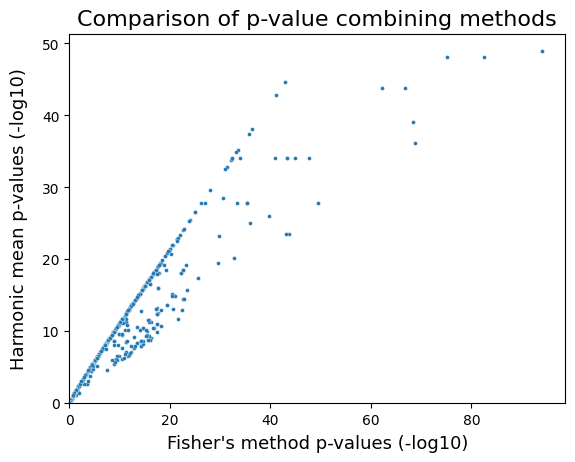

In [25]:
sns.scatterplot(x=log_combined_pvals_fisher, y=log_combined_pvals_hmean,s=8)       #color='#FFD580',s=10
                
plt.title('Comparison of p-value combining methods',fontsize=16)
plt.xlabel("Fisher's method p-values (-log10)",fontsize=13, labelpad=5)
plt.ylabel("Harmonic mean p-values (-log10)",fontsize=13, labelpad=10) 

plt.xlim(0,)   #-log_10(0.005) = 2.301...
plt.ylim(0,)


#Changing the axis limits to focus on the boundary 
#plt.xlim(0,-np.log10(0.005)+1.5)   #-log_10(0.005) = 2.301...
#plt.ylim(0,-np.log10(0.005)+1.5)

#plt.axvline(x=-np.log10(0.005), color='r', linewidth=0.1, linestyle='-')
#plt.axhline(y=-np.log10(0.005), color='r', linewidth=0.1, linestyle='-')

#plt.savefig('Figures/p_val_combining_methods.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [10]:
#Using harmonic mean p-value method 
edge_data = {e:combined_pvals_hmean[index] for index,e in enumerate(proteomic_copy.edges & metabolomic_copy.edges) } # for e in proteomic_copy.edges & metabolomic_copy.edges
nx.set_edge_attributes(G, edge_data, 'Spearman_pval')

In [11]:
#Get the average for the Spearman correlation coefficients and the overlap coefficient
#HOWEVER it is not recommended to take the average of the p-values, thus we combine them using one of two methods: Fisher's method OR harmonic p-value

def add_attributes(attribute_name):
    edge_data = {e: ((proteomic_copy.edges[e][attribute_name] + metabolomic_copy.edges[e][attribute_name])/2) for e in proteomic_copy.edges & metabolomic_copy.edges}
    nx.set_edge_attributes(G, edge_data, attribute_name)


#Print all edge information (data=True means to display edge attribute data as well)
#print(G.edges(data=True))             

add_attributes("Squared_corr")
add_attributes("Overlap_coef")


print(proteomic_copy.edges['R-HSA-112315', 'R-HSA-1483257'])
print(metabolomic_copy.edges['R-HSA-112315', 'R-HSA-1483257'])
print(G.edges['R-HSA-112315', 'R-HSA-1483257'])

#print(proteomic_copy.edges['R-HSA-2262752', 'R-HSA-8978868'])
#print(metabolomic_copy.edges['R-HSA-2262752', 'R-HSA-8978868'])
#print(G.edges['R-HSA-2262752', 'R-HSA-8978868'])


{'Squared_corr': 0.7246532748646831, 'Spearman_pval': 3.560702971632539e-19, 'Overlap_coef': 0.0}
{'Squared_corr': 0.10747970859180164, 'Spearman_pval': 1.0, 'Overlap_coef': 0.2}
{'Squared_corr': 0.4160664917282424, 'Spearman_pval': 7.121405943265078e-19, 'Overlap_coef': 0.1}


In [12]:
#Filter out edges based on Spearman p-value and Overlap Coefficient
edges_to_remove = [(u,v) for u,v,e in G.edges(data=True) if (e['Spearman_pval'] >= 0.005 or e['Overlap_coef'] >= 0.5)]
len(edges_to_remove)

681

In [13]:
G.remove_edges_from(edges_to_remove)
print(G.number_of_nodes())
print(G.number_of_edges())
G.nodes()

47
400


NodeView(('R-HSA-112315', 'R-HSA-1428517', 'R-HSA-1483257', 'R-HSA-156580', 'R-HSA-15869', 'R-HSA-1592230', 'R-HSA-168249', 'R-HSA-196071', 'R-HSA-196849', 'R-HSA-196854', 'R-HSA-211859', 'R-HSA-211945', 'R-HSA-2142753', 'R-HSA-2151201', 'R-HSA-2187338', 'R-HSA-2262752', 'R-HSA-2408508', 'R-HSA-2408522', 'R-HSA-2980736', 'R-HSA-372790', 'R-HSA-373076', 'R-HSA-381340', 'R-HSA-388396', 'R-HSA-416476', 'R-HSA-418555', 'R-HSA-418594', 'R-HSA-428157', 'R-HSA-500792', 'R-HSA-556833', 'R-HSA-5663205', 'R-HSA-5668914', 'R-HSA-5683826', 'R-HSA-597592', 'R-HSA-6806667', 'R-HSA-70326', 'R-HSA-71291', 'R-HSA-71387', 'R-HSA-71406', 'R-HSA-73884', 'R-HSA-8956319', 'R-HSA-8956321', 'R-HSA-8957322', 'R-HSA-8978868', 'R-HSA-9707564', 'R-HSA-9707616', 'R-HSA-9711123', 'R-HSA-975634'))

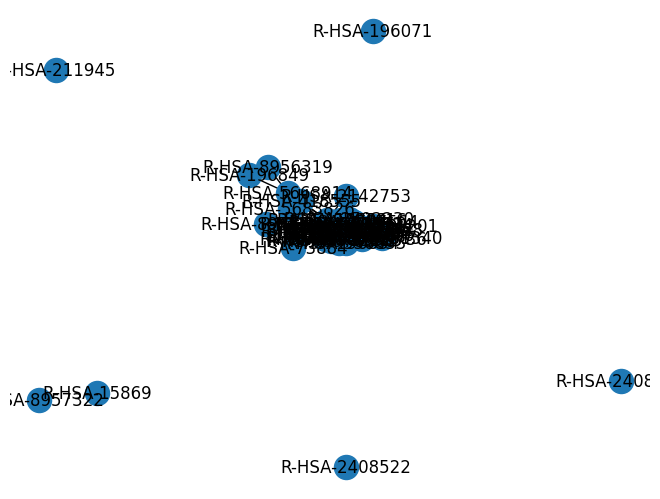

In [14]:
nx.draw(G, with_labels = True)

### Method 2 - Filter out edges separately by Spearman p-value then average out the Spearman correlation and Overlap Coefficient

In [ ]:
#Filter out edges based on Spearman p-value and Overlap Coefficient
edges_to_remove_proteomic = [(u,v) for u,v,e in proteomic_copy.edges(data=True) if (e['Spearman_pval'] >= 0.05 )]
print(len(edges_to_remove_proteomic))

edges_to_remove_metabolomic = [(u,v) for u,v,e in metabolomic_copy.edges(data=True) if (e['Spearman_pval'] >= 0.05 )]
print(len(edges_to_remove_metabolomic))

edges_to_remove = set( edges_to_remove_proteomic + edges_to_remove_metabolomic )
print(len(edges_to_remove))

G = nx.compose(proteomic_copy,metabolomic_copy)
print(G.edges['R-HSA-112315', 'R-HSA-1483257'])

def add_attributes(attribute_name):
    edge_data = {e: ((proteomic_copy.edges[e][attribute_name] + metabolomic_copy.edges[e][attribute_name])/2) for e in proteomic_copy.edges & metabolomic_copy.edges}
    nx.set_edge_attributes(G, edge_data, attribute_name)


#Print all edge information (data=True means to display edge attribute data as well)
#print(G.edges(data=True))             

add_attributes("Squared_corr")
add_attributes("Overlap_coef")


print(proteomic_copy.edges['R-HSA-112315', 'R-HSA-1483257'])
print(metabolomic_copy.edges['R-HSA-112315', 'R-HSA-1483257'])
print(G.edges['R-HSA-112315', 'R-HSA-1483257'])

G.remove_edges_from(edges_to_remove)
print(G.number_of_nodes())
print(G.number_of_edges())
G.nodes()

#Filter out edges based on Spearman p-value and Overlap Coefficient
edges_to_remove = [(u,v) for u,v,e in G.edges(data=True) if e['Overlap_coef'] >= 0.5]
len(edges_to_remove)

G.remove_edges_from(edges_to_remove)
print(G.number_of_nodes())
print(G.number_of_edges())
G.nodes()

### Setting node attributes (Next stage after running either Method 1 or Method 2)

In [15]:
#Nodes with no edges
nodes_to_remove = list(nx.isolates(G))
nodes_to_remove

#['R-HSA-196071', 'R-HSA-2151201']

['R-HSA-15869',
 'R-HSA-196071',
 'R-HSA-211945',
 'R-HSA-2408508',
 'R-HSA-2408522',
 'R-HSA-8957322']

In [16]:
#nodes_to_remove=['R-HSA-196071']
G.remove_nodes_from(nodes_to_remove)

In [17]:
#IF YOU DON'T REMOVE THE EDGES, DON'T RUN THIS CODE

#Add the betweenness centrality as a node attribute
betweenness= nx.betweenness_centrality(G, normalized=True) #output as dictionary
#display(betweenness)
nx.set_node_attributes(G, betweenness, "betweenness")

#Add the betweenness centrality as a node attribute
degree= nx.degree_centrality(G) #output as dictionary
#display(degree)
nx.set_node_attributes(G, degree, "degrees")


#Check
#G.nodes['R-HSA-112315']#["betweenness"]
#G.nodes['R-HSA-196071']#["betweenness"]

In [18]:
#Using Cecilia's code

#Creating graph
hierarchy = pd.read_csv('Data/ReactomePathwaysRelation.txt', sep='\t', header=None)

#From the pathways, subset to Homo sapiens only
hierarchy_hsa = hierarchy[hierarchy[0].str.contains('HSA')]

#Return unique values in the first column that is not in the second column as a numpy array
#These values are not child pathways in any instances
hierarchy_hsa_parents = np.setdiff1d(hierarchy_hsa[0], hierarchy_hsa[1])

#Add the unique values not in the second column as a second attached dataset to the bottom of the original data
#The first column represents the parent column, the second column is the child column
hierarchy_hsa_all = pd.concat([hierarchy_hsa, pd.DataFrame([hierarchy_hsa_parents, hierarchy_hsa_parents], index=[0, 1]).T])

#DiGraph is a directed graph
H = nx.from_pandas_edgelist(hierarchy_hsa, source=0, target=1, create_using=nx.DiGraph())


In [19]:
#Find the root pathway 

def find_root(H,child):
    #Find parent from child 
    parent = list(H.predecessors(child))

    #Keep the loop going until the highest level is reached
    if len(parent) == 0:
        return child
    else:  
        return find_root(H, parent[0])

hierarchy_hsa_all['Root'] = [find_root(H, i) for i in hierarchy_hsa_all[1]]

hierarchy_hsa_all.columns = ['Parent', 'Child', 'Root']

#There are 83 instances of duplicates, however all the child duplicates have the same root (even though different parents) after checking



#Convert pathway ID to name
root_path = pd.read_excel('Data/Root_pathways.xlsx', header=None)
root_pathway_dict = {root_path[0][i]:root_path[1][i] for i in range(0,len(root_path))}



#Assign name to each node
root_pathways = {}
for pathway in list(H.nodes):
    index = hierarchy_hsa_all.Child[hierarchy_hsa_all.Child == pathway].index.tolist()[0]
    root_pathway  = hierarchy_hsa_all.Root[index]
    label = root_pathway_dict[root_pathway]
    root_pathways[pathway] = label




In [20]:
#shows all the root pathways in Reactome
set(hierarchy_hsa_all['Root'] )
#shows all the root pathways present in the original dataset
set(root_pathways.values())

nx.set_node_attributes(G, root_pathways, "root_pathway")

print(G.number_of_nodes()) 

41


In [21]:
#for some reason, not sure if really clustering such spearman_coef works with a typo 
#i think it works though, since changing the name gives a diff num of clusters even with seed set
louvain_clusters = nx.community.louvain_communities(G, weight='Spearman_coef',seed=100,resolution=1.5)
print(len(louvain_clusters))

louvain_dict = {}
for index,grouping in enumerate(louvain_clusters):
    for pathway in grouping:
        louvain_dict[pathway] = index+1

nx.set_node_attributes(G, louvain_dict, "louvain")
    

20


Note that I use different pathway files for the separate metabolomics and proteomics data (since different compounds form the pathways), however since we take the intersection of the compounds for data integration it is fine to use the metabolomics pathways file to load in the pathway names.

In [22]:
reactome_pathways = sspa.process_gmt("Data/Reactome_Homo_sapiens_pathways_compounds_R84.gmt")

pathway_name_dict = {reactome_pathways.index[i]:reactome_pathways["Pathway_name"][i] for i in range(0,len(reactome_pathways))}
pathway_name_dict['R-HSA-1483257']
pathway_name_dict = {k:pathway_name_dict[k] for k in list(G.nodes)}
#G = nx.relabel_nodes(G, pathway_name_dict)
nx.set_node_attributes(G, pathway_name_dict, "pathway_name")
G.nodes

NodeView(('R-HSA-112315', 'R-HSA-1428517', 'R-HSA-1483257', 'R-HSA-156580', 'R-HSA-1592230', 'R-HSA-168249', 'R-HSA-196849', 'R-HSA-196854', 'R-HSA-211859', 'R-HSA-2142753', 'R-HSA-2151201', 'R-HSA-2187338', 'R-HSA-2262752', 'R-HSA-2980736', 'R-HSA-372790', 'R-HSA-373076', 'R-HSA-381340', 'R-HSA-388396', 'R-HSA-416476', 'R-HSA-418555', 'R-HSA-418594', 'R-HSA-428157', 'R-HSA-500792', 'R-HSA-556833', 'R-HSA-5663205', 'R-HSA-5668914', 'R-HSA-5683826', 'R-HSA-597592', 'R-HSA-6806667', 'R-HSA-70326', 'R-HSA-71291', 'R-HSA-71387', 'R-HSA-71406', 'R-HSA-73884', 'R-HSA-8956319', 'R-HSA-8956321', 'R-HSA-8978868', 'R-HSA-9707564', 'R-HSA-9707616', 'R-HSA-9711123', 'R-HSA-975634'))

In [23]:
print(G.number_of_nodes())
print(G.number_of_edges())
G.edges['R-HSA-112315', 'R-HSA-1483257']#["Spearman_pval"]
G.nodes['R-HSA-112315']#["betweenness"]

41
400


{'betweenness': 0.007854630713067506,
 'degrees': 0.75,
 'root_pathway': 'Neuronal System ',
 'louvain': 3,
 'pathway_name': 'Transmission across Chemical Synapses'}

In [24]:
#nx.write_gml(G,'Cytoscape/integrated_commonsamples_harmonic.gml')
#nx.write_gml(G,'Cytoscape/integrated_all_harmonic.gml')
#nx.write_gml(G,'Cytoscape/integrated_mildcases_harmonic.gml')
#nx.write_gml(G,'Cytoscape/integrated_severecases_harmonic.gml')